<h2>Abstract</h2>
<p>
各プロテニス選手には、サーブが得意な選手やリターンが得意な選手がいると思います。<br>
このノートブックでは、各プロテニス選手にはサーブ力とリターン力の潜在変数があると仮定し、これを因子分析で推定し、選手ごとのサーブ力・リターン力を定量化することを試みます。<br>
<br>
====================================<br>
<br>
I think there are some pro-tennis player who is good at serve and some pro-tennis player who is good at return.<br>
In this notebook, I assume that each professional tennis player has latent variables for serve and return strength, which estimate using factor analysis and try to quantify the serve and return strength of each player.<br>
</p>

<h2>(1) Library</h2>

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pylab as plt
import seaborn as sns

from src.constants import (
    INTERMEDIATE_DATA_DIR,
    INTERMEDIATE_DATA_MATCHES,
    INTERMEDIATE_DATA_RATES,
    ANALYZE_TARGET_COLS,
)
from src.functions import (
    read_raw_data,
    save_intermediate_data,
    read_intermediate_rates_data,
    preprocess,
    fit_factor_analysis,
    plot_factor_analysis_result,
    make_result_df,
    plot_top_bottom_factor,
    show_target_player_factor,
)

<h2>(2) Load data</h2>
<p>
以下のデータセットには、プロテニス選手の各試合ごとの詳細データが記録されています。<br>
ファーストサーブが成功した回数、取得できたポイント、セカンドサービスが成功した回数、取得できたポイント、リターンから取得できたポイントなどが今回の分析に使えそうです。<br>
<br>
<a href="https://www.kaggle.com/ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting">https://www.kaggle.com/ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting</a><br>
<br>
====================================<br>
<br>
Following data set contains detailed data for each pro-tennis player's matches.<br>
The number of successful first serves, points obtained, number of successful second serves, points obtained, and points obtained from returns may be used for this analysis.<br>
<br>
<a href="https://www.kaggle.com/ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting">https://www.kaggle.com/ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting</a>
</p>

In [2]:
df_matches = read_raw_data()
df_matches.shape

(2556, 40)

In [3]:
save_intermediate_data(
    df=df_matches,
    save_path=INTERMEDIATE_DATA_DIR / INTERMEDIATE_DATA_MATCHES,
    index=True,
)

PosixPath('/project/data/intermediate/all_matches_chunk_preprocessed.csv')

<h2>(3) Preprocess</h2>
<p>
各試合でどのくらいのポイントが実施されたかが異なりますので、試合中でのファーストサーブの成功率、ポイント率、セカンドサービスの成功率、ポイント率、リターンのポイント率に変換します。<br>
また、チャレンジャーなどの下位の試合データまで含まれており、分析対象が多くなりすぎるので、今回は以下の条件に限定した試合データ・選手を対象にします。<br>
<br>
- 2016年以降に開催<br>
- グランドスラム<br>
- 10回以上勝利しているプレイヤー<br>
<br>
====================================<br>
<br>
Convert data info first serve success rate, point rate, second serve success rate, point rate, and return point rate due to it's difference how many points for each matches.<br>
In addition, data contains lower-level matches such as Challenger, which would make an analysis too large, so I filter match and player by following conditions.<br>
<br>
- The matches were held in 2016 later<br>
- Grand Slam<br>
- Players who have won at least 10 times<br>
</p>

In [4]:
df_rates = preprocess(df_matches)
print("Target player num: {}".format(len(df_rates)))

Target player num: 81


<h2>(4) Save as an intermediate</h2>

In [5]:
save_intermediate_data(
    df=df_rates,
    save_path=INTERMEDIATE_DATA_DIR / INTERMEDIATE_DATA_RATES,
    index=True,
)

PosixPath('/project/data/intermediate/rates.csv')

In [6]:
df_rates = read_intermediate_rates_data()

<h2>(5) Check Corr. serve, return point rates</h2>
<p>
まずは各カラムで相関をとってみて、サーブ力の因子・リターン力の因子が仮定できそうか確認してみます。<br>
<br>
====================================<br>
<br>
First, let's get correlate for each column and see if it can be  assumed a factor of serve power and a factor of return power.<br>
</p>

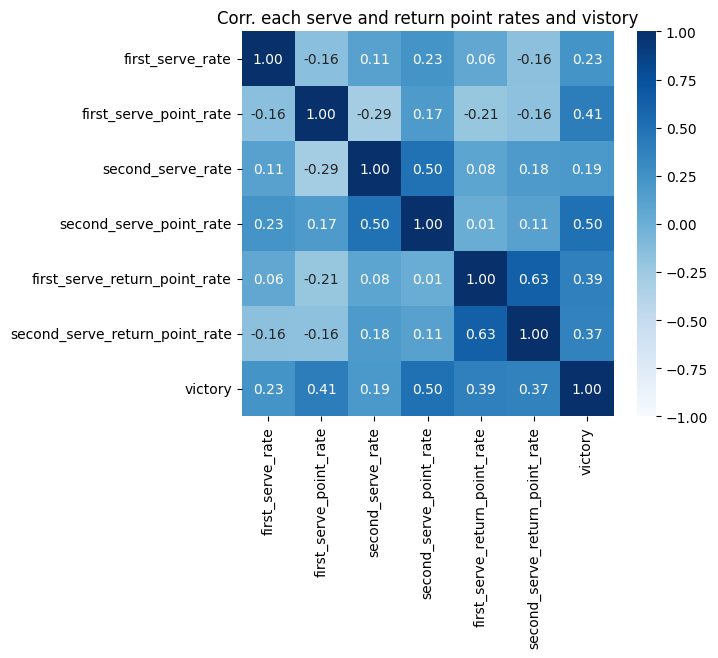

In [7]:
plt.figure(figsize=(6, 5))
sns.heatmap(df_rates.corr(), annot=True, vmax=1, vmin=-1, fmt=".2f", cmap="Blues")
plt.title("Corr. each serve and return point rates and vistory")
plt.show()

<h2>Insights [1]:</h2>
<p>
これを見る限り、ファースト、セカンド両方とも、精度とポイント率はあまり相関しないようです。<br>
当然ですが、勝敗に対して相関があるのは、精度よりもポイント率の方です。<br>
プロレベルになると、もうサーブの精度は一定以上あって、よりその後のゲームメイクの方が重要になるようです。<br>
<br>
また、意外だったのが、ファーストサービスからのポイント率とセカンドサービスからのポイント率が相関していないという点でした。<br>
サービス後のゲーム展開が得意な選手の中でも、それがファーストの場合は得意であっても、セカンドの場合は得意とは限らないようです。<br>
<br>
一方、リターンに関しては予想通りで、リターンが得意な選手は、相手がファーストでもセカンドでも、いずれも強い傾向があるようです。<br>
<br>
この結果を受けて、最初の仮定では、因子の数=2(サーブ力・リターン力)と仮定していましたが、因子の数=3(ファーストサービスのゲームメイク力・セカンドサービスのゲームメイク力・リターン力)が潜在していると解釈できる結果になりそうな気がしてきました。<br>
実際に分析にかけてみないと分からないので、因子数を2,3,4で設定して、各結果について、因子負荷量と各選手の因子得点の様子を確認してみます。<br>
<br>
====================================<br>
<br>
According to the above result, It doesn't seem to correlate between success rate and point rate for first serve and second serve.<br>
Of course, it's the point rates more correlate with win than success rate.<br>
At the pro-level, it seems that the success rate of a serve is already above a certain level, so subsequent game-making is more important to get a point.<br>
<br>
What was also surprising was that the point rate from a first serve doesn't correlate with the point rate from a second serve.<br>
Even among players who are good at game-making after service, it seems that even if they are good at it when it is a first serve, they are not necessarily good at it when it is the second serve.<br>
<br>
On the other hand, it seems that players who are good at returns tend to be strong in both cases, whether the opponent is a first serve or a second serve.<br>
<br>
Based on these results, I was initially assuming that the number of factors = 2 (serve and return strength), but it may better that number of factors = 3 (first service game-making strength, second service game-making strength, and return strength).<br>
It will not know until I actually analyze, so let's analyze with setting the number of factors = 2,3,4 and check the factor loadings and factor scores.<br>
</p>

<h2>(6) Factor Analysis</h2>

<h3>n_factor = 2</h3>

,first_serve_rate,first_serve_point_rate,second_serve_rate,second_serve_point_rate,first_serve_return_point_rate,second_serve_return_point_rate
factor0,0.009646,0.249973,-0.324085,-0.208977,-0.745535,-0.794291
factor1,-0.248257,-0.001915,-0.630198,-0.675892,0.218597,0.122462


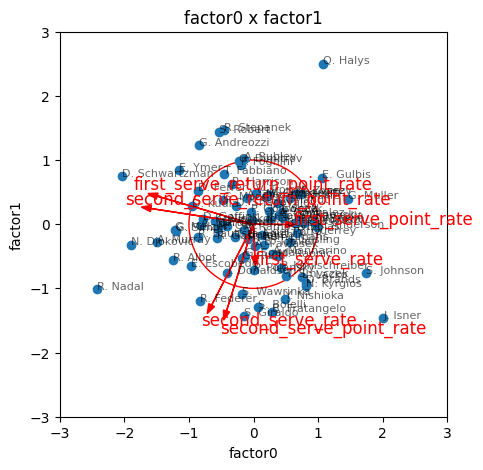

In [8]:
n_factor = 2
x = df_rates[ANALYZE_TARGET_COLS].values
y = df_rates.index

# Factor analysis
fa2 = fit_factor_analysis(x=x, n_factor=n_factor)

# Plot
transformed2 = plot_factor_analysis_result(x=x, y=y, n_factor=n_factor, fa=fa2)

<h3>n_factor = 3</h3>

,first_serve_rate,first_serve_point_rate,second_serve_rate,second_serve_point_rate,first_serve_return_point_rate,second_serve_return_point_rate
factor0,-0.020160,-0.220032,0.391780,0.413493,0.601223,0.883986
factor1,-0.203896,-0.467122,-0.304557,-0.827799,0.276294,0.266019
factor2,0.327522,-0.753182,0.441881,0.166780,-0.066059,-0.207630


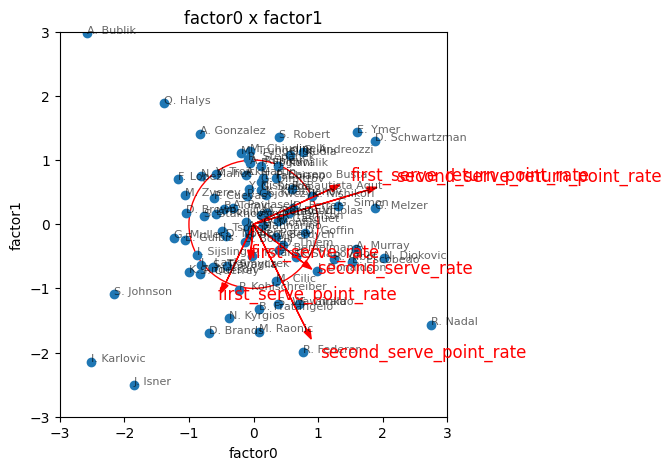

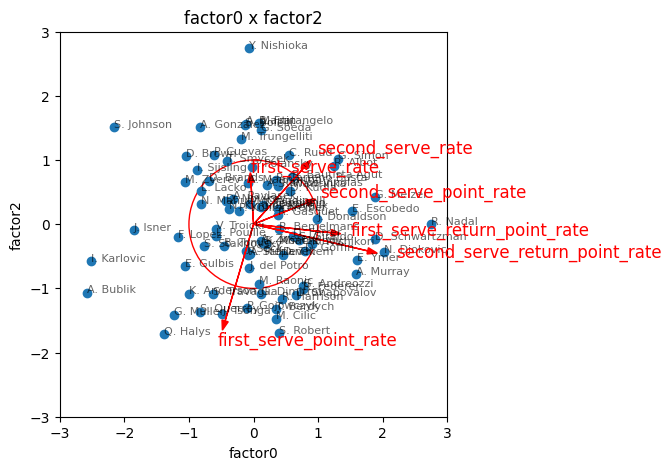

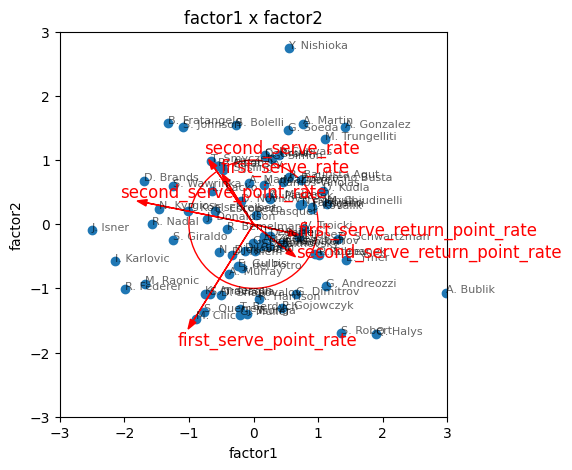

In [9]:
n_factor = 3
x = df_rates[ANALYZE_TARGET_COLS].values
y = df_rates.index

# Factor analysis
fa3 = fit_factor_analysis(x=x, n_factor=n_factor)

# Plot
transformed3 = plot_factor_analysis_result(x=x, y=y, n_factor=n_factor, fa=fa3)

<h3>n_factor = 4</h3>

,first_serve_rate,first_serve_point_rate,second_serve_rate,second_serve_point_rate,first_serve_return_point_rate,second_serve_return_point_rate
factor0,-0.162621,0.250234,-0.617862,-0.584696,-0.540619,-0.641784
factor1,0.312862,0.281124,0.316052,0.610075,-0.525115,-0.514107
factor2,0.437134,-0.674095,0.232298,-0.202021,-0.027653,-0.221004
factor3,-0.547751,-0.178024,0.344089,-0.048379,-0.262244,0.000468


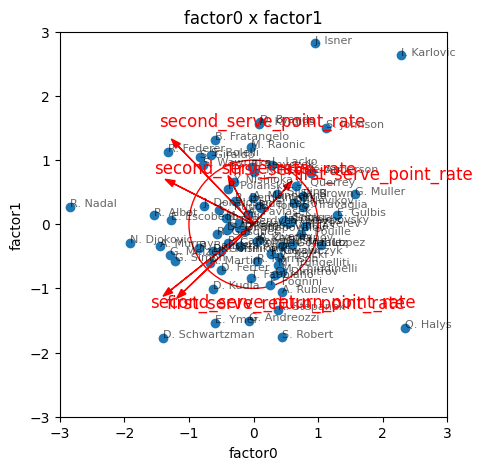

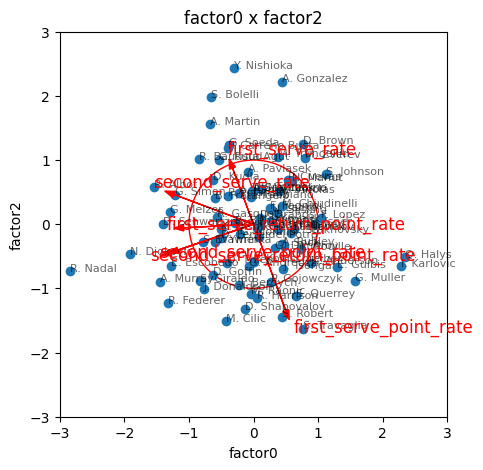

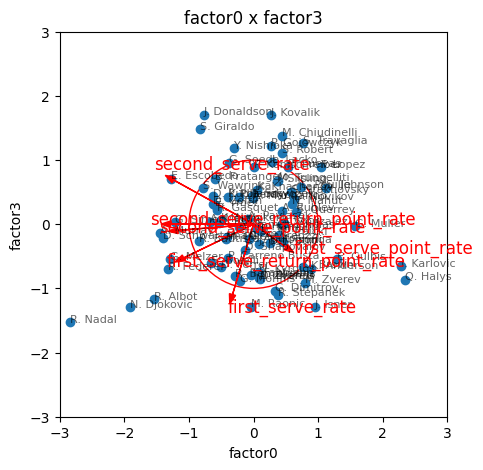

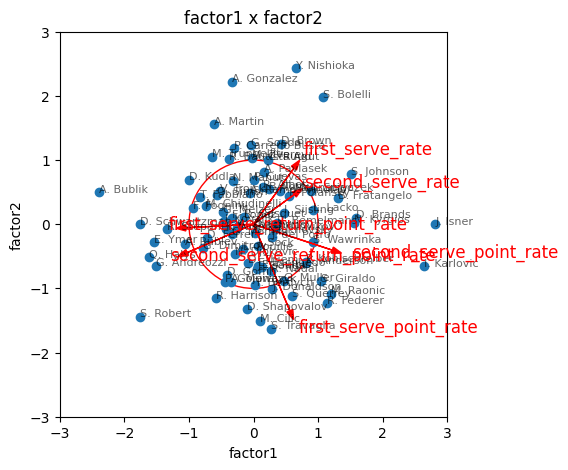

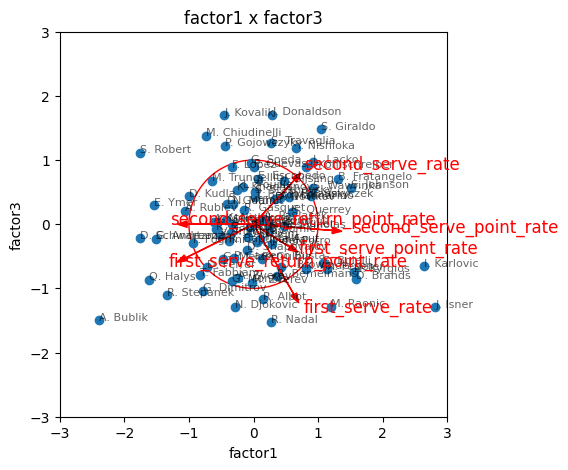

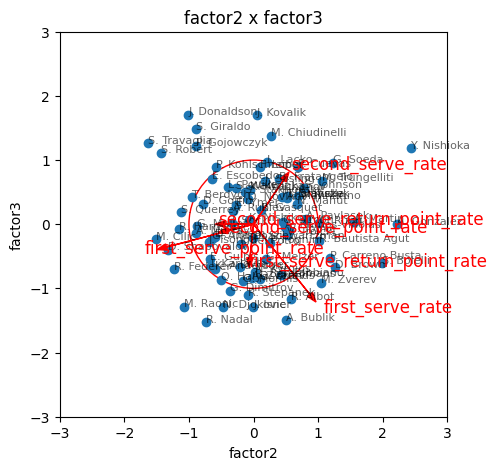

In [10]:
n_factor = 4
x = df_rates[ANALYZE_TARGET_COLS].values
y = df_rates.index

# Factor analysis
fa4 = fit_factor_analysis(x=x, n_factor=n_factor)

# Plot
transformed4 = plot_factor_analysis_result(x=x, y=y, n_factor=n_factor, fa=fa4)

<h2>Insights [2]:</h2>

<p>
<b>--- 因子数=2の場合 ---</b><br>
<br>
リターン力に関しては1つの因子として取れそうですが、サーブに関する情報がうまくまとまらなさそうです。<br>
<br>
<b>--- 因子数=3の場合 ---</b><br>
<br>
因子負荷量を見ても、やはりこれが一番しっくりきそうです。<br>
第1因子がリターン力、第2因子がセカンドサービスでのポイント力、第3因子がファーストサービスでのポイント力として表現できそうです。<br>
<br>
因子得点の3つ目のグラフを見ると、見事に左下にビッグサーバー選手が集まっていて面白いです。<br>
ファーストサービス方向にチリッチやクエリー、アンダーソンなどの選手がいて、かつセカンドサービス方向にも強いと位置しているのが、フェデラーやラオニッチ、カルロビッチといった選手で、サービスが武器と言われている選手の中でも、勝率としてより成功している選手は、両方の軸で強い位置に出てきているように見えます。<br>
<br>
リターン力で見ると、ナダルやジョコビッチ、シュワルツマンなどが強いようです。<br>
重なって見えづらいですが、錦織圭も強い位置にいます。<br>
<br>
<b>--- 因子数=4の場合 ---</b><br>
<br>
因子負荷量の絶対値がどれもそこそこの大きさになってしまって、どの因子が何を表しているのか分からなくなってしまいました。<br>
<br>
<b>結論として</b><br>
<br>
今回のデータからは、因子はファーストサービスのゲームメイク力・セカンドサービスのゲームメイク力・リターン力の3つから生成されると解釈した方が良さそうです。<br>
<br>
====================================<br>
<br>
<b>--- If number of factors = 2 ---</b><br>
<br>
It seems it can take it one factor as return strength, but it may can't put together the info on serves.<br>
<br>
<b>--- If number of factors = 3 ---</b><br>
<br>
According to the factor loadings, this case seems to be appropriate.<br>
The first factor seems to be return strength, the second factor be as point strength from a second serve, and the third factor be as point strength from a first serve.<br>
<br>
Looking at the third graph of factor scores, it is interesting to see that the big serve players are clustered in the lower left corner.<br>
Cilic, Querrey, and Anderson in the first service direction and also positioned as strong in the second serve direction are Federer, Raonic, and Karlovic, who are more successful players who their service is their weapon, they seem to be coming in the position stronger on both axis.<br>
<br>
In return strength, Nadal, Djokovic, and Schwartzman seem to be the stronger players.<br>
Kei Nishikori is also in a strong position.<br>
<br>
<b>--- If number of factors = 4 ---</b><br>
<br>
The absolute values of all factor loadings have become halfway value, so it cannot show which factor represents what.<br>
<br>
<b>Result</b><br>
<br>
From this data, it seems better to interpret that generate three factors: first serve game-making strength, second serve game-making strength, and return strength.<br>
</p>

<h2>(7) Check Corr. each factor vs victory</h2>

In [11]:
df_results = make_result_df(
    y=y,
    transformed=transformed3,
    n_factor=3,
    plus_minus_list=["plus", "minus", "minus"],
    victory_rates=df_rates['victory'].values.reshape(len(y), 1),
)

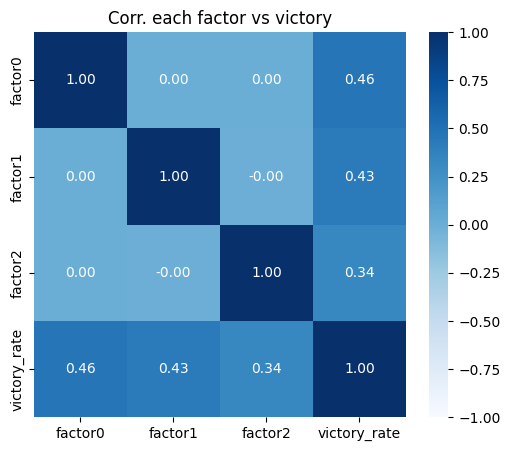

In [12]:
plt.figure(figsize=(6, 5))
sns.heatmap(df_results.corr(), annot=True, vmax=1, vmin=-1, fmt=".2f", cmap="Blues")
plt.title("Corr. each factor vs victory")
plt.show()

<h2>(8) Check player ranking of each factor</h2>

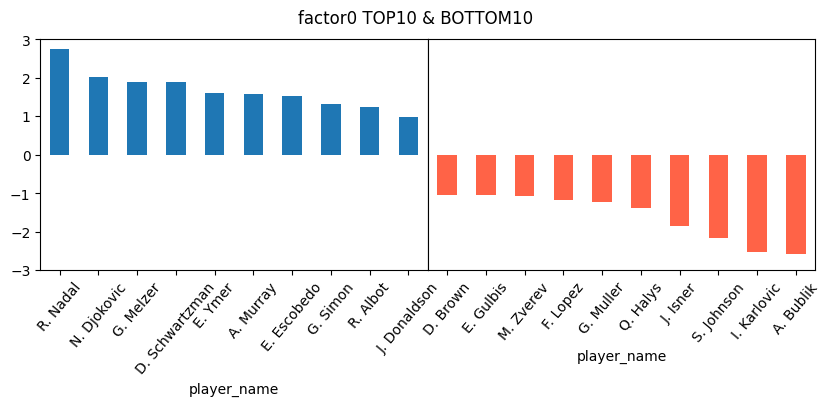

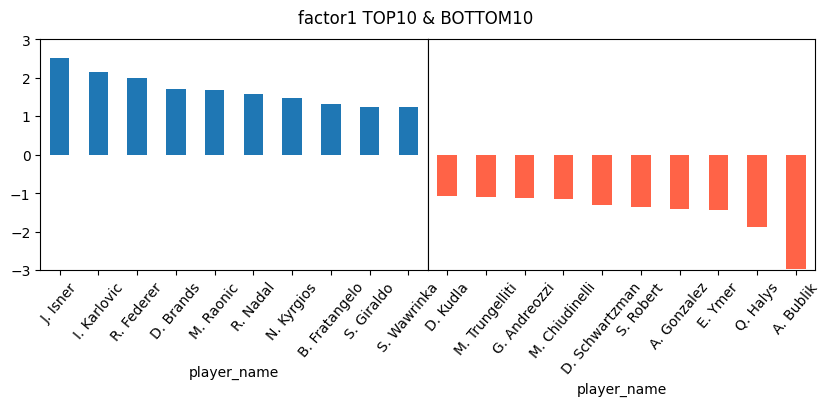

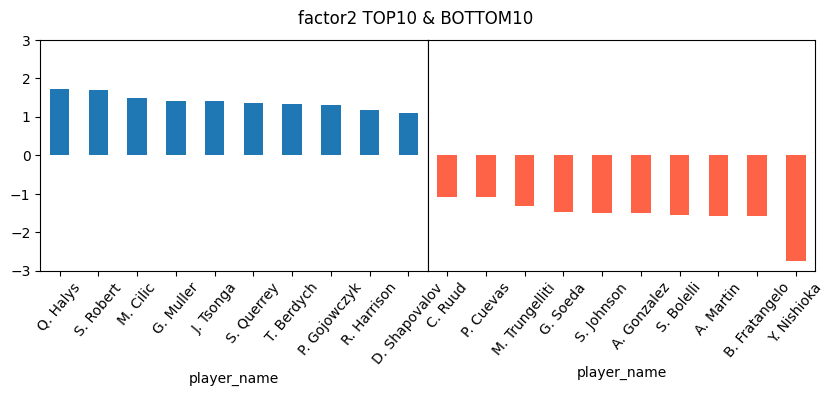

In [13]:
for i in range(3):
    plot_top_bottom_factor(df_res=df_results, target_factor=f"factor{i}")

<h2>(9) How about K. Nishikori ?</h2>

In [14]:
show_target_player_factor(df_res=df_results, n_factor=3, target_player="K. Nishikori")

K. Nishikori
factor0 : 11 th / 81
factor1 : 54 th / 81
factor2 : 31 th / 81


<p>
リターン力はかなりの上位に来ていて、その一方で、セカンドサーブからやられてしまう傾向があるみたいようです。<br>
これは試合を見ていても割と納得できる結果となりました。<br>
<br>
====================================<br>
<br>
His return strength is coming in pretty high, on the other hand, he seems to have a tendency to get hit from his second serve.<br>
This was a rather convincing result when watching the match.<br>
</p>